# Numerical analysis of the Steinberg signature on more complex linear framework graphs. 

# Haque, Çetiner, Gunawardea 2024. _Anomalous behavior of the Steinberg signature for detecting departure from thermodynamic equilibrium._

Here, we demonstrate how to use the `general-graphs` library developed for quantitative analysis of the Steinberg signature on any strongly connected, fully reversible linear framework graph. In the development of this software, the NetworkX library for Python 3 was used. For more information on NetworkX, see https://networkx.org/documentation/stable/index.html

In this notebook, we will do the following. 

1. Create a random linear framework graph $G$ that is **strongly connected** and **fully reversible**.
2. Find a parameterization for $G$ such that $G$ exists in an equilibrium steady state 
3. Calculate the Steinberg signature $\mathcal{I}^{\alpha,\beta}(G)$
4. Drive the system represented by $G$ away from equilibrium by progressively modifying a single parameter
5. Plot the Steinberg signature $\mathcal{I}^{\alpha,\beta}(G)$ against the cycle affinity $\tilde{A}(C)$ of the driven cycle

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from general_graph_utils import *

# Plot features

In [2]:
# plot formatting
plt.rc("text", usetex=False) # renders LaTeX more quickly
plt.rc("font", family = "serif",size=14) # font specifications
plt.rc("figure",figsize=(14,12)) # figure size
%config InlineBackend.figure_format = 'retina' # retina-display quality

In [4]:
G = nx.DiGraph()
G.add_node(1)
G.add_node(2)
G.add_node(3)
G.add_node(4)
G.add_edge(1, 2)
G.add_edge(2, 1)
G.add_edge(2, 3)
G.add_edge(3, 2)
G.add_edge(4, 3)
G.add_edge(3, 4)
G.add_edge(1, 4)
G.add_edge(4, 1)
#G.add_edge(2, 4)
#G.add_edge(4, 2)

In [5]:
G_ud = nx.Graph()
G_ud.add_node(1)
G_ud.add_node(2)
G_ud.add_node(3)
G_ud.add_node(4)
G_ud.add_edge(1, 2)
G_ud.add_edge(2, 1)
G_ud.add_edge(2, 3)
G_ud.add_edge(3, 2)
G_ud.add_edge(4, 3)
G_ud.add_edge(3, 4)
G_ud.add_edge(1, 4)
G_ud.add_edge(4, 1)
#G_ud.add_edge(2, 4)
#G_ud.add_edge(4, 2)

In [6]:
print(G)

DiGraph with 4 nodes and 8 edges


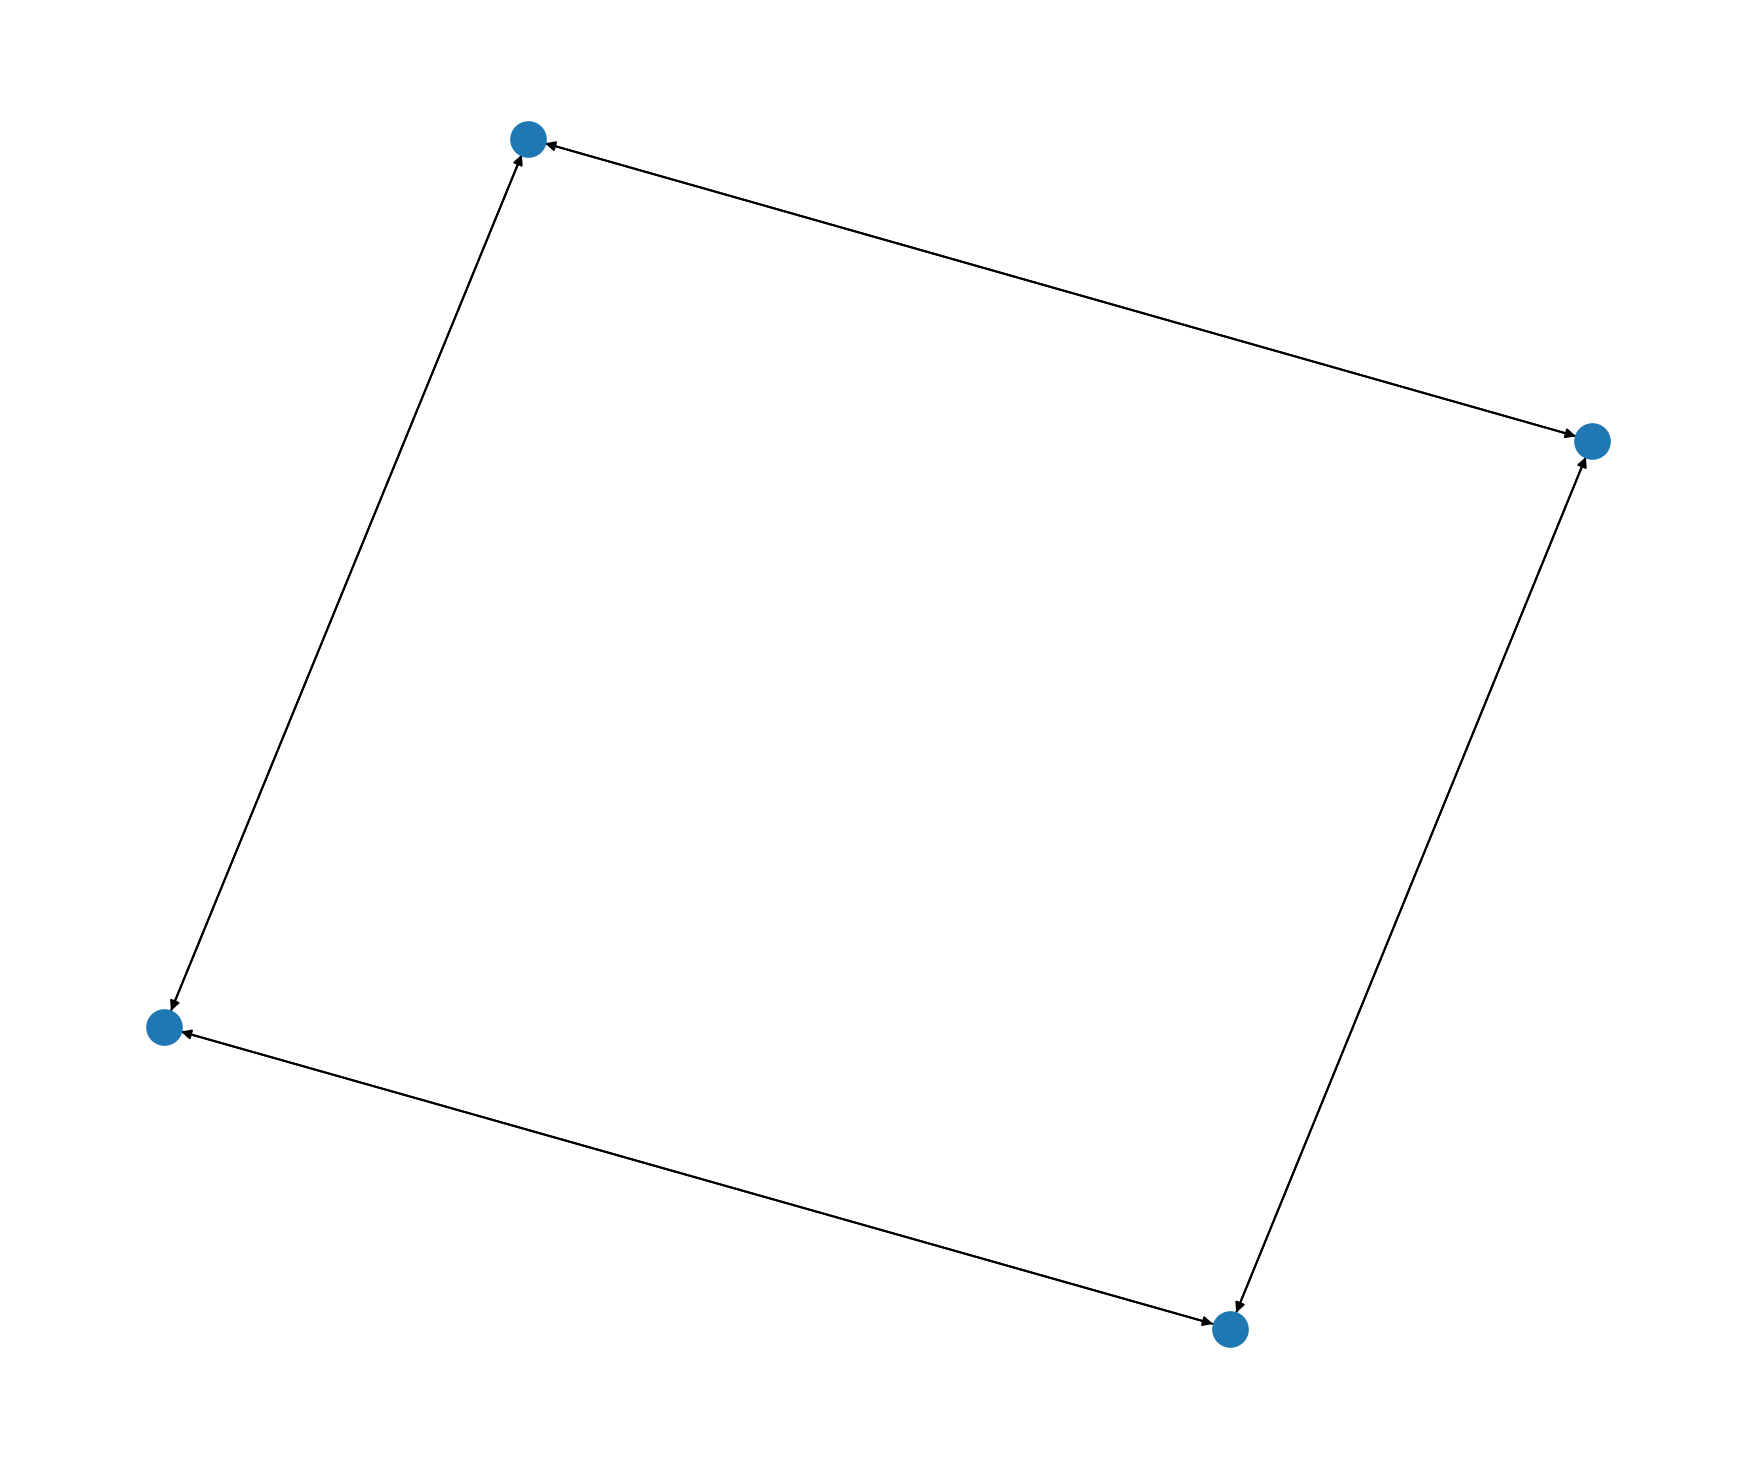

In [9]:
nx.draw(G)
plt.savefig('G_4_diagram_unicycle.png')

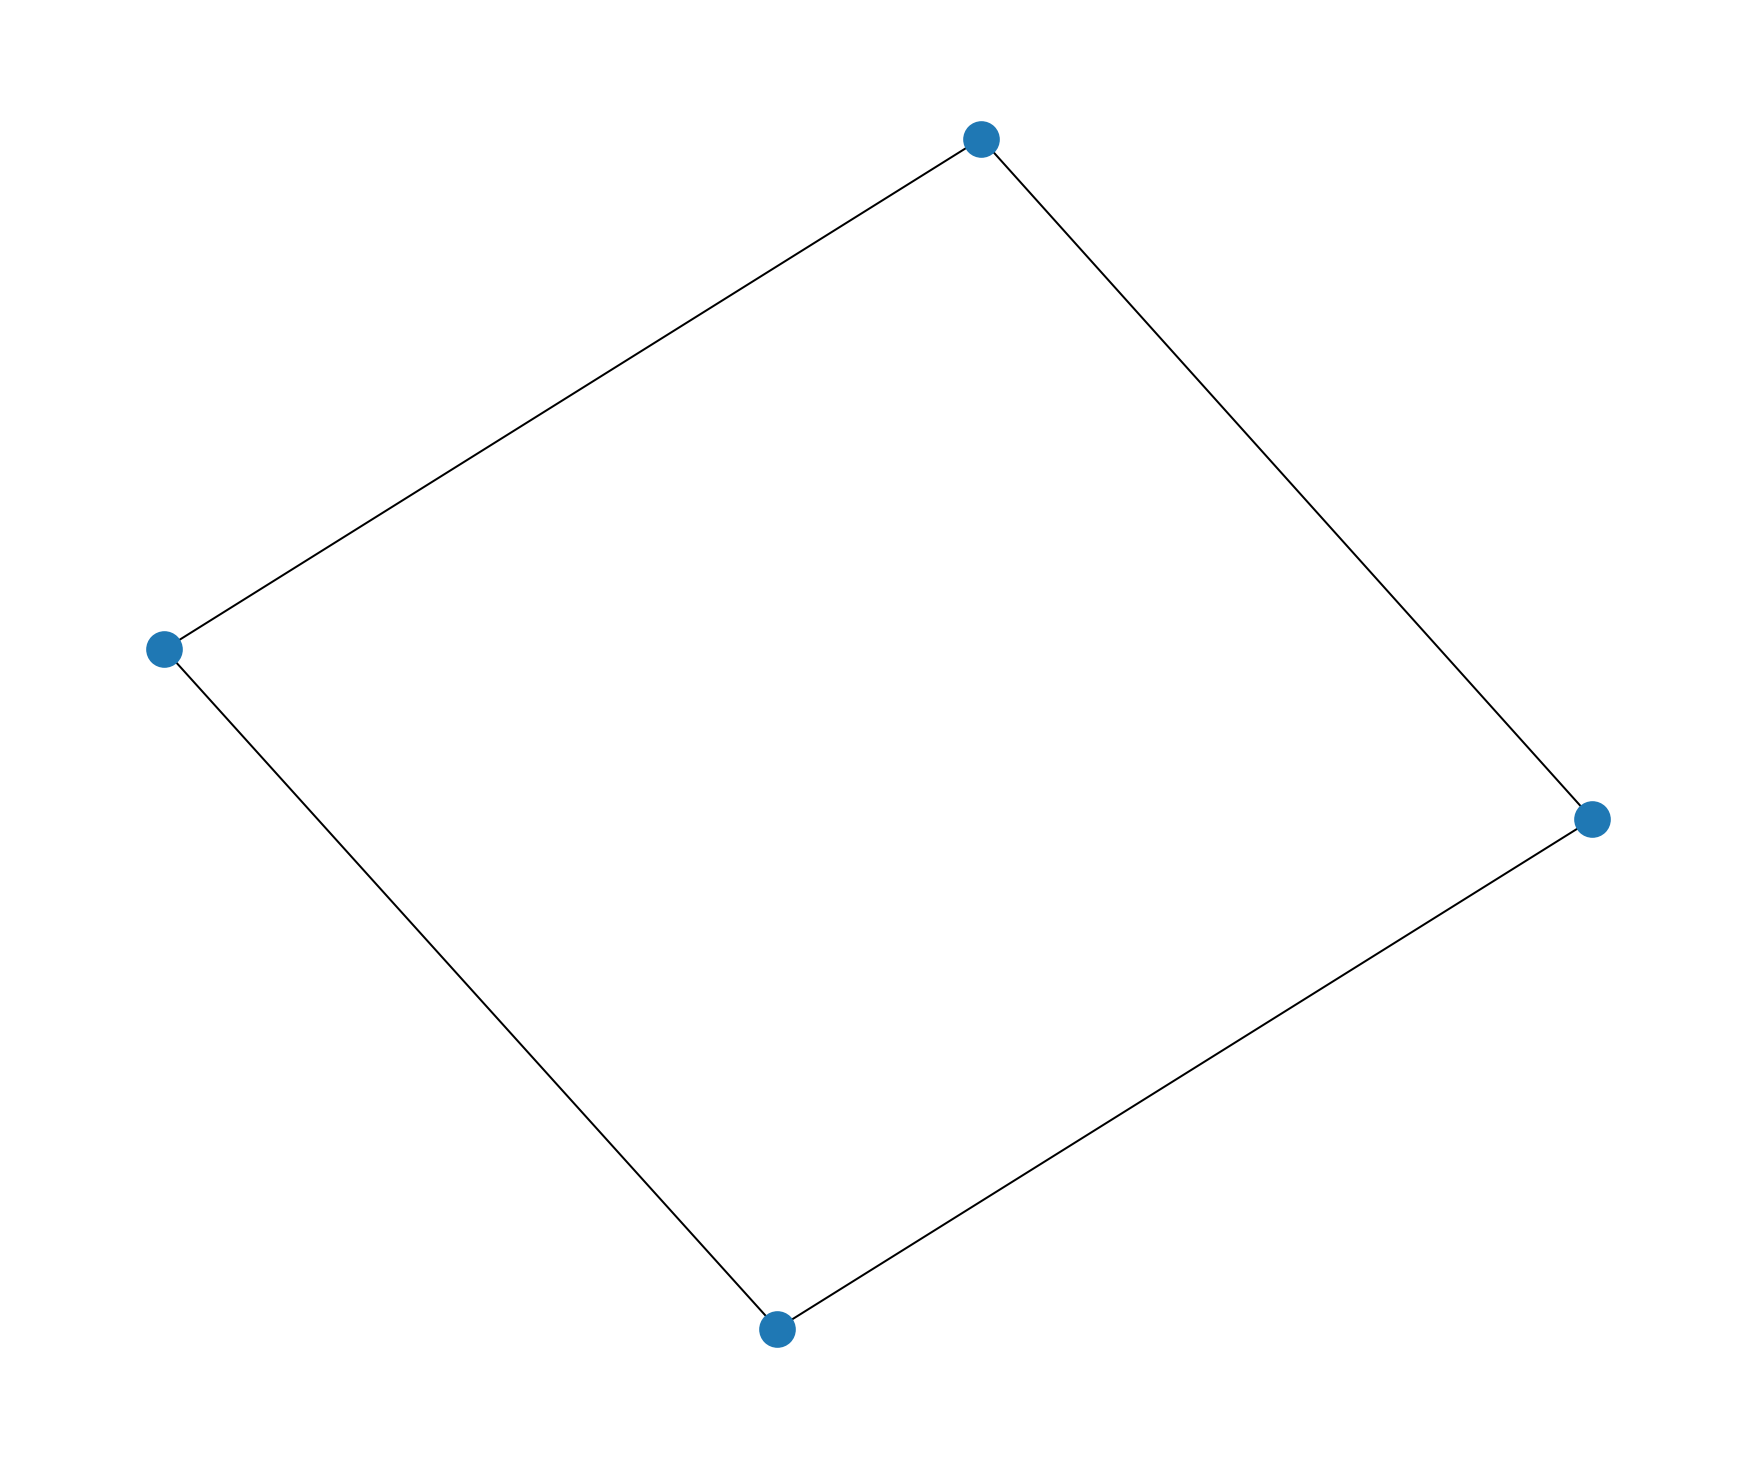

In [10]:
nx.draw(G_ud)

### 1.1. Create data structures containing the graph's structural information.

Next, we will assign structural information from `G` and `G_ud` to specific data structures, which will be necessary to compute quantities such as the cycle affinity.

Let's begin with the nodes and the edges of $G$.

`node_list`: a ***1D NumPy array*** of the nodes in $G$.

In [11]:
node_list = get_nodes(G)
print(node_list)

[1 2 3 4]


`edge_list`: a ***1D NumPy array*** of the edges in $G$. Each directed edge $i \to j$ between vertices $i$ and $j$ is represented as a list `[i j]`.

In [12]:
edge_list = get_edges(G)
print(edge_list)

[[1 2]
 [1 4]
 [2 1]
 [2 3]
 [3 2]
 [3 4]
 [4 3]
 [4 1]]


Let $C = i \leftrightharpoons 1 \leftrightharpoons 2 \leftrightharpoons \cdots \leftrightharpoons j \leftrightharpoons i$ represent a cycle of reversible edges in a graph. Linear framework graphs can be broken down into cycles (see the work of Terrell Hull and Johannes Schnakenberg for more details on taking a graph theoretic approach to stochastic thermodynamics), which is done by specifying a **cycle basis**.

To define a cycle basis, we take advantage of the NetworkX function `nx.cycle_basis`. More information can be found here: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cycles.cycle_basis.html

`cycle_list`: a ***list of lists*** of the nodes involved in each cycle in $G$. Note that `G_ud`, not `G`, is required here.

`num_cycles`: number of cycles in $G$. This will be an essential parameter in later computations.

In [13]:
cycle_list = get_cycle_nodes(G_ud)
num_cycles = len(cycle_list)
print(cycle_list)
print(num_cycles)

[[2, 3, 4, 1]]
1


### 1.2. Specify a parameterization of $G$

To define edge labels for $G$, we use the following algorithm. If G is not already labeled, the labels are logarithmically sampled from the range $[10^{-3},10^3]$. 

The function returns the following data structures.

`label_dict`: a ***dictionary*** matching each edge to its corresponding label. The keys are the edges (listed as a tuple $(i,j)$ for each directed edge $i\to j$ and the values are the associated labels.

`label_list`: a ***1D NumPy array*** containing a list of the labels in $G$. The order is the same as in `edge_list`, which can be confirmed from `label_dict`

In [15]:
label_dict = {(1, 2): 1.0, (1, 4): 1.0, (2, 1): 1.0, (2, 3): 1.0, (3, 2): 1.0, (3, 4): 1.0, (4, 1): 1.0, (4, 3): 1.0}
label_list = np.fromiter(label_dict.values(), dtype=float)
print(label_dict)
print(label_list)
len(label_list)

{(1, 2): 1.0, (1, 4): 1.0, (2, 1): 1.0, (2, 3): 1.0, (3, 2): 1.0, (3, 4): 1.0, (4, 1): 1.0, (4, 3): 1.0}
[1. 1. 1. 1. 1. 1. 1. 1.]


8

Going forward, it will be useful to specify which edges (and their corresponding labels) are associated with each cycle and to separate forward and backward traversals of each cycle. The next algorithm generates data structures that separate this information.

`cycle_edges_forward`: a ***list of lists*** where each element is a list of the edges going around one direction ("forward") of a given cycle

`cycle_edges_backward`: a ***list of lists*** where each element is a list of the edges going around the opposite direction ("backward") of a given cycle

`cycle_labels_forward`: a ***list of lists*** where each element is a list of the labels associated with the forward edges

`cycle_labels_backward`: a ***list of lists*** where each element is a list of the labels associated with the backward edges

Note that each of these data structures are ***lists of lists***. The indexing for all of them works as follows.

`cycle_edges_forward[i][j]` refers to edge `j` in cycle `i`. `cycle_labels_forward[i][j]` refers to the label on edge `j` in cycle `i`.

In [16]:
cycle_edges_forward,cycle_edges_backward,cycle_labels_forward,cycle_labels_backward = get_cycle_labels_edges(cycle_list,label_dict)

In [17]:
print(cycle_edges_forward)
print(cycle_edges_backward)

[[(2, 3), (3, 4), (4, 1), (1, 2)]]
[[(3, 2), (4, 3), (1, 4), (2, 1)]]


In [18]:
print(cycle_labels_forward)
print(cycle_labels_backward)

[[1.0, 1.0, 1.0, 1.0]]
[[1.0, 1.0, 1.0, 1.0]]


### 1.3. Calculate the cycle affinity for each cycle in the graph

The cycle affinity is a dimensionless quantity that serves as a measure of thermodynamic force (see J Schnakenberg 1986). Mathematically, we define the cycle affinity in the following way. Recall that $C = i \leftrightharpoons 1 \leftrightharpoons 2 \leftrightharpoons \cdots \leftrightharpoons j \leftrightharpoons i$ represents a cycle of reversible edges in a graph. For any cycle $C$, the cycle affinity $\tilde{A}(C)$ is given by

$$ \tilde{A}(C) = \log { \left ( \dfrac{\ell(i\to 1)\ell(1\to 2)\cdots \ell(j \to i)}{\ell(1\to i)\ell(2\to 1)\cdots \ell(i \to j)} \right ) } $$

where $\ell(a \to b)$ is the label on the directed edge $a \to b$. To compute this quantity for each cycle in our graph object `G`, we must complete the following steps.

1. Calculate the products of edge labels in each direction around each cycle.
2. Take the log of the ratio of the forward and backwards products for each cycle

`products_f`: a ***1D NumPy array*** where each element is the product of labels corresponding to the forward traversal of each cycle

`products_b`: a ***1D NumPy array*** where each element is the product of labels corresponding to the backward traversal of each cycle

In [19]:
products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)

In [20]:
print(products_f)
print(products_b)

[1.]
[1.]


`total_affinities`: a ***1D NumPy array*** where each element is the thermodynamic force for each cycle in the graph, corresponding to their order in cycle_list

In [21]:
total_affinities = calculate_affinities(products_b, products_f, cycle_list)

In [22]:
print(total_affinities)

[0.]


### 1.4 Calculate the Laplacian matrix $L$ and the steady state distribution $\pi$ of $G$

`L`: the Laplacian matrix of the graph

In [23]:
L = Laplacian_all(edge_list, label_list, node_list)
print(L)

[[-2.  1.  0.  1.]
 [ 1. -2.  1.  0.]
 [ 0.  1. -2.  1.]
 [ 1.  0.  1. -2.]]


`pi`: the steady-state distribution of $G$

In [24]:
eigvals, eigvecs = scipy.linalg.eig(L)
pi = np.array([eigvecs[:,np.argmin(np.abs(eigvals))].real/sum(eigvecs[:,np.argmin(np.abs(eigvals))].real)]).T
print(pi)
print(eigvals)

[[0.25]
 [0.25]
 [0.25]
 [0.25]]
[ 2.22044605e-16+0.j -2.00000000e+00+0.j -4.00000000e+00+0.j
 -2.00000000e+00+0.j]


## 2. Set the graph in an equilibrium steady state

Linear framework graphs represent biochemical systems. The vertices represent components of a system, and edges are treated as chemical reactions under mass-action kinetics with the labels as rate constants (Gunawardena 2012). The dynamics on this system relaxes to a **steady-state** when $dx/dt = 0$, where $x$ is a column vector of component amounts.

Furthermore, we can define two types of steady-states: equilibrium and non-equilibrium. An equilibrium steady-state is characterized by the lack of net fluxes of matter and energy. Detailed balance holds for each pair of reversible edges, and the cycle affinity for each cycle is equal to 0. 

In [25]:
cycle_labels_forward, edge_tracker = initial_equilibrium_parameters(cycle_list,cycle_edges_forward,cycle_labels_forward,cycle_labels_backward)

In [26]:
cycle_labels_forward

[[1.0, 1.0, 1.0, 1.0]]

In [27]:
products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)
total_affinities = calculate_affinities(products_f, products_b, cycle_list)
print(total_affinities)

[0.]


## 3. Calculate the Steinberg signature

The Steinberg signature is a signature of non-equilibrium conditions in Markovian systems. Using higher-order autocorrelation functions of the form $G^{\alpha,\beta}(\tau)$ and $G^{\beta,\alpha}(\tau)$, this method allows one to detect whether or not a given system obeys detailed balance. 

We can use the Steinberg signature to detect if the parameterization of a particular linear framework graph obeys detailed balance or not. The Steinberg signature takes multiple forms, including the following formula.

$$G^{\alpha,\beta}(\tau) = f^\alpha e^{L \tau} f^{* \beta} \pi$$

We will first define some quantities that will pass as variables in the Steinberg function. We will then compute the Laplacian matrix of the graph. Finally, when we have all the requisite components, we can compute the Steinberg signature.

`observable`: the vector $f$ in the above expression.

In [28]:
observable = make_observable(node_list)
print(observable)

[3. 5. 7. 9.]


`tau_n`: a vector of possible values of $\tau$. $\tau$ represents the interval.

In [29]:
tau_n = np.arange(start=0.01,stop=20.0,step=0.01)

In [30]:
label_dict, label_list = reformat_labels(cycle_list, cycle_labels_forward, edge_tracker, label_dict, label_list)

In [31]:
print(label_dict)

{(1, 2): 1.0, (1, 4): 1.0, (2, 1): 1.0, (2, 3): 1.0, (3, 2): 1.0, (3, 4): 1.0, (4, 1): 1.0, (4, 3): 1.0}


In [32]:
L = np.around(Laplacian_all(edge_list, label_list, node_list),decimals=4)
print(L)

[[-2.  1.  0.  1.]
 [ 1. -2.  1.  0.]
 [ 0.  1. -2.  1.]
 [ 1.  0.  1. -2.]]


`t`: forward higher-order autocorrelation function $G^{\alpha,\beta}(\tau)$

`t_rev`: reverse higher-order autocorrelation function $G^{\beta, \alpha}(\tau)$

In [33]:
%%time
t, t_rev = autocorrelation_analytical(observable,L,tau_n,alpha=1,beta=3)

CPU times: user 1.36 s, sys: 24.3 ms, total: 1.38 s
Wall time: 1.43 s


In [34]:
area = np.abs(np.trapz(t)-np.trapz(t_rev))
print(area)

1.318767317570745945e-11


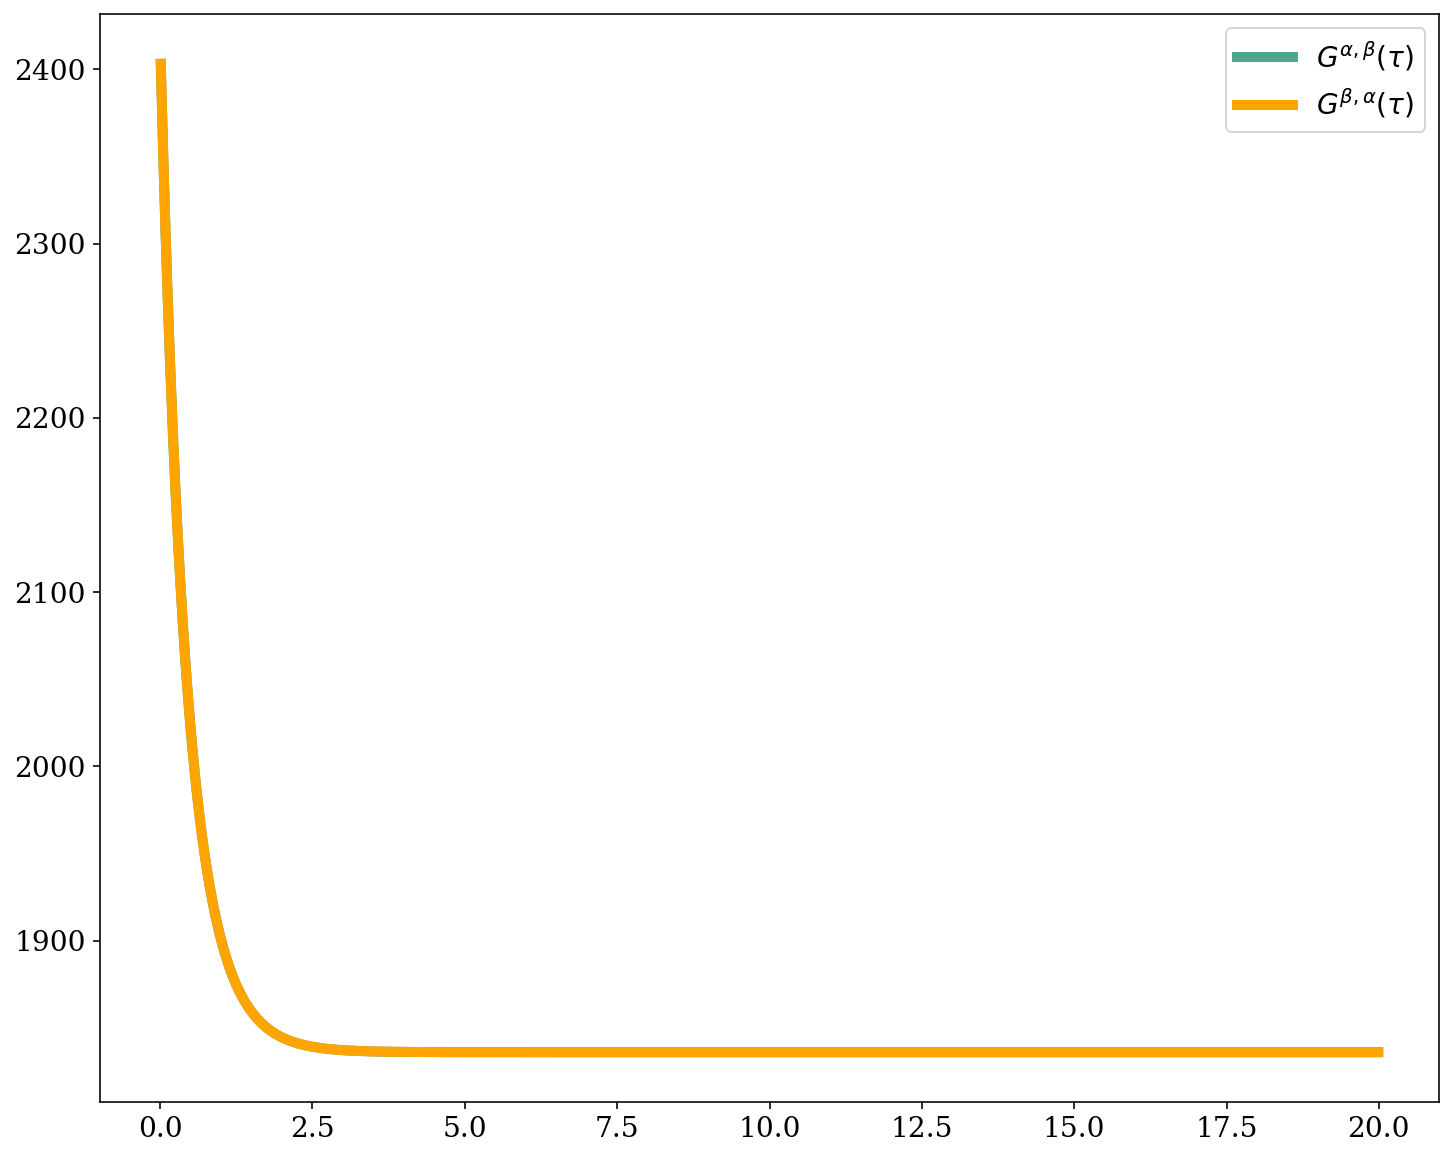

In [35]:
fig = plt.figure()
plt.plot(tau_n,t_rev,color='#4CA98F',linewidth=5,label=r'$G^{\alpha,\beta}(\tau)$')
plt.plot(tau_n,t,c= '#FFA400',linewidth=5,label=r'$G^{\beta,\alpha}(\tau)$')
plt.legend()

In [36]:
t, t_rev = autocorrelation_analytical(observable,L,tau_n,alpha=1,beta=3)

In [37]:
area = np.abs(np.trapz(t)-np.trapz(t_rev))
print(area)

1.318767317570745945e-11


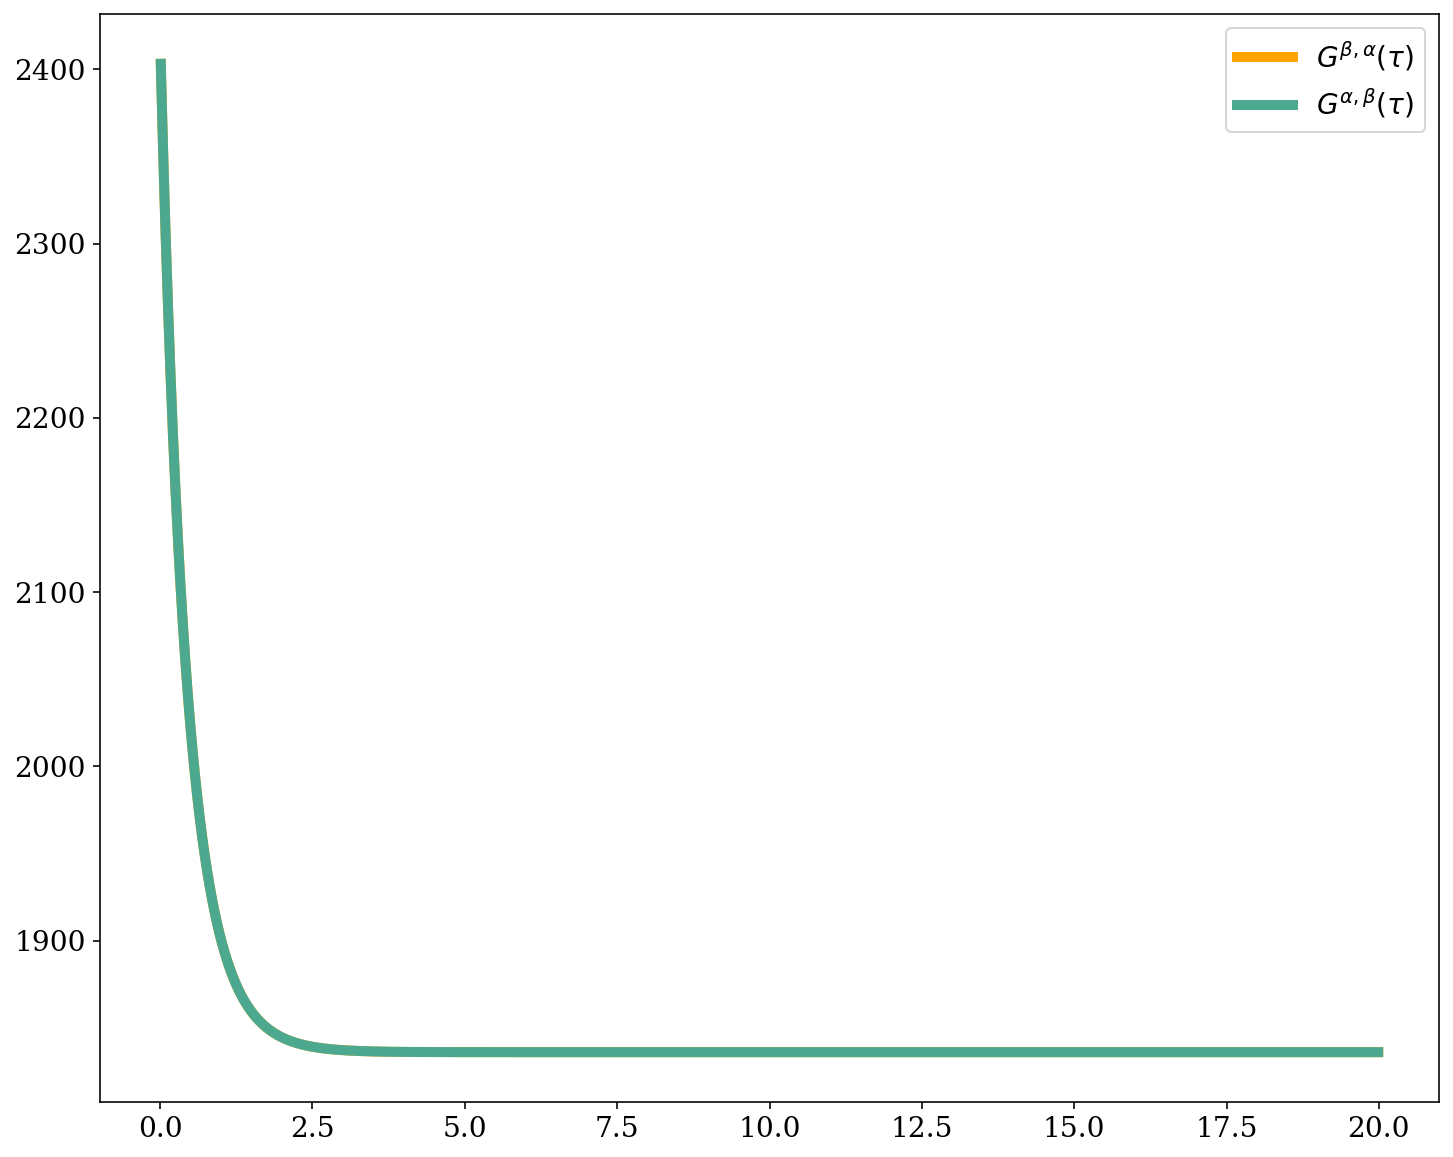

In [38]:
fig = plt.figure()
plt.plot(tau_n,t,c= '#FFA400',linewidth=5,label=r'$G^{\beta,\alpha}(\tau)$')
plt.plot(tau_n,t_rev,color='#4CA98F',linewidth=5,label=r'$G^{\alpha,\beta}(\tau)$')
plt.legend()
#fig.savefig('max tau 10 not big enough for this set.png', dpi = 900, bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')

## 4. Perturb a single parameter progressively from its equilibrium value

The goal of developing this software was to determine the sensitivity of the Steinberg signature to the thermodynamic force of the underlying system.

In [39]:
cycle_idx = np.random.choice(np.arange(num_cycles))
cycle_idx

0

In [40]:
edge_idx = np.random.choice(np.arange(len(cycle_labels_forward[cycle_idx])))
edge_idx

2

In [41]:
param_choice = cycle_labels_forward[cycle_idx][edge_idx]
print(param_choice)
edge = cycle_edges_forward[0][0]
print(edge)

1.0
(2, 3)


In [42]:
N = 1000
all_affinities = np.zeros((N,num_cycles))
all_areas = np.zeros((N,1))
param_changes = np.zeros((N,1))

In [43]:
print(cycle_list)

[[2, 3, 4, 1]]


In [44]:
for i in tqdm(range(0,N)):
    
    # calculate affinity + record
    products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)
    total_affinities = calculate_affinities(products_f,products_b,cycle_list)
    all_affinities[i] = total_affinities
        
    # calculate area + record
    label_dict, label_list = reformat_labels(cycle_list, cycle_labels_forward, edge_tracker, label_dict, label_list)
    L = Laplacian_all(edge_list,label_list,node_list)
    t, t_rev = autocorrelation_analytical(observable,L,tau_n,alpha=1,beta=3)
    all_areas[i] = np.abs(np.trapz(t)-np.trapz(t_rev))
        
    # perturb parameter + record
    param_changes[i] = cycle_labels_forward[0][0]
    cycle_labels_forward[0][0] = cycle_labels_forward[0][0]*1.01

100%|███████████████████████████████████████| 1000/1000 [22:26<00:00,  1.35s/it]


In [45]:
cycle_labels_forward[cycle_idx][edge_idx] = cycle_labels_forward[cycle_idx][edge_idx]*1.01
cycle_labels_forward[cycle_idx][edge_idx]

1.01

## 5. Plot the resulting force-area curve

In [46]:
print(label_dict)

{(1, 2): 1.0, (1, 4): 1.0, (2, 1): 1.0, (2, 3): 20751.639245360224, (3, 2): 1.0, (3, 4): 1.0, (4, 1): 1.0, (4, 3): 1.0}


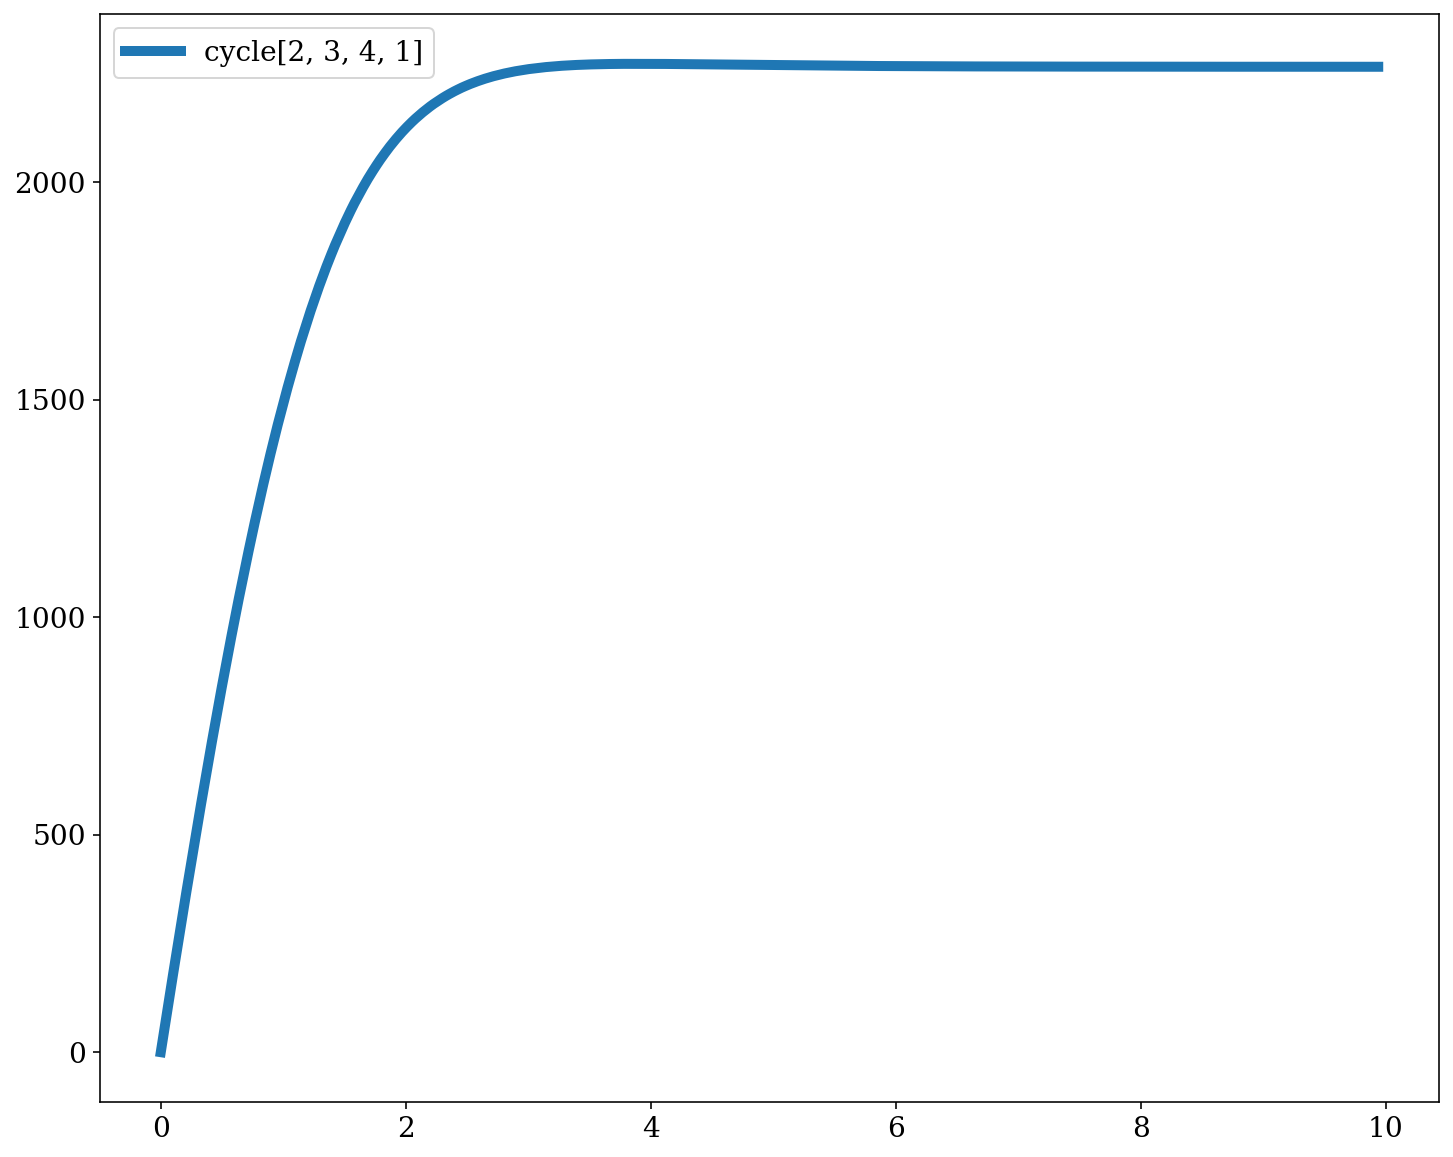

In [47]:
fig = plt.figure()
for i in range(0,num_cycles):
    plt.plot(all_affinities[:,i],all_areas, linewidth=5,label='cycle'+str(cycle_list[i]))
plt.legend()
#fig.savefig('forcearea_affinity-G4-threecycle.png', dpi = 900, bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')

## 1. Create a general graph with a random number of nodes and randomly assigned edges.

To generate a random linear framework graph, you first must decide the maximum number of nodes you want in your graph. Set that number as `n`. Then, define a directed graph `G` and an undirected graph `G_ud` as the outputs of the function `random_graph(n)`. `G` and `G_ud` are graph objects as defined by the NetworkX library.

`random_graph(n)` picks a random number between 3 and `n` to be the size of the graph, adds that many nodes to the graph, and then assigns edges between the nodes such that the resulting graph is strongly connected and fully reversible. To ensure that the graph is strongly connected, we make use of the NetworkX function `nx.is_strongly_connected(G)`. If `nx.is_strongly_connected(G) == False`, then a pair of nodes in G are selected at random and reversible edges are added between them. This continues until `nx.is_strongly_connected(G) == True`. 

It is necessary to have a directed and undirected version of the graph for the various functions that we will use going forward. Also, to clarify notation in this Jupyter notebook, $G$ refers to the mathematical object defined by the linear framework, while `G` and `G_ud` refer to graph objects defined in this numerical simulation using the NetworkX library.

In [4]:
n=10
G,G_ud = random_graph(n)

To generate the graphs from the paper, we will manually set up the 4-vertex graph

In [5]:
G = nx.DiGraph()
G.add_node(1)
G.add_node(2)
G.add_node(3)
G.add_node(4)
G.add_edge(1, 4)
G.add_edge(4, 1)
G.add_edge(3, 4)
G.add_edge(4, 3)
G.add_edge(3, 2)
G.add_edge(2, 3)
G.add_edge(4, 2)
G.add_edge(2, 4)
G.add_edge(1, 2)
G.add_edge(2, 1)

G_ud = nx.Graph()
G_ud.add_node(1)
G_ud.add_node(2)
G_ud.add_node(3)
G_ud.add_node(4)
G_ud.add_edge(1, 4)
G_ud.add_edge(4, 1)
G_ud.add_edge(3, 4)
G_ud.add_edge(4, 3)
G_ud.add_edge(3, 2)
G_ud.add_edge(2, 3)
G_ud.add_edge(4, 2)
G_ud.add_edge(2, 4)
G_ud.add_edge(1, 2)
G_ud.add_edge(2, 1)

In [6]:
print(G)
print(G_ud)

DiGraph with 4 nodes and 10 edges
Graph with 4 nodes and 5 edges


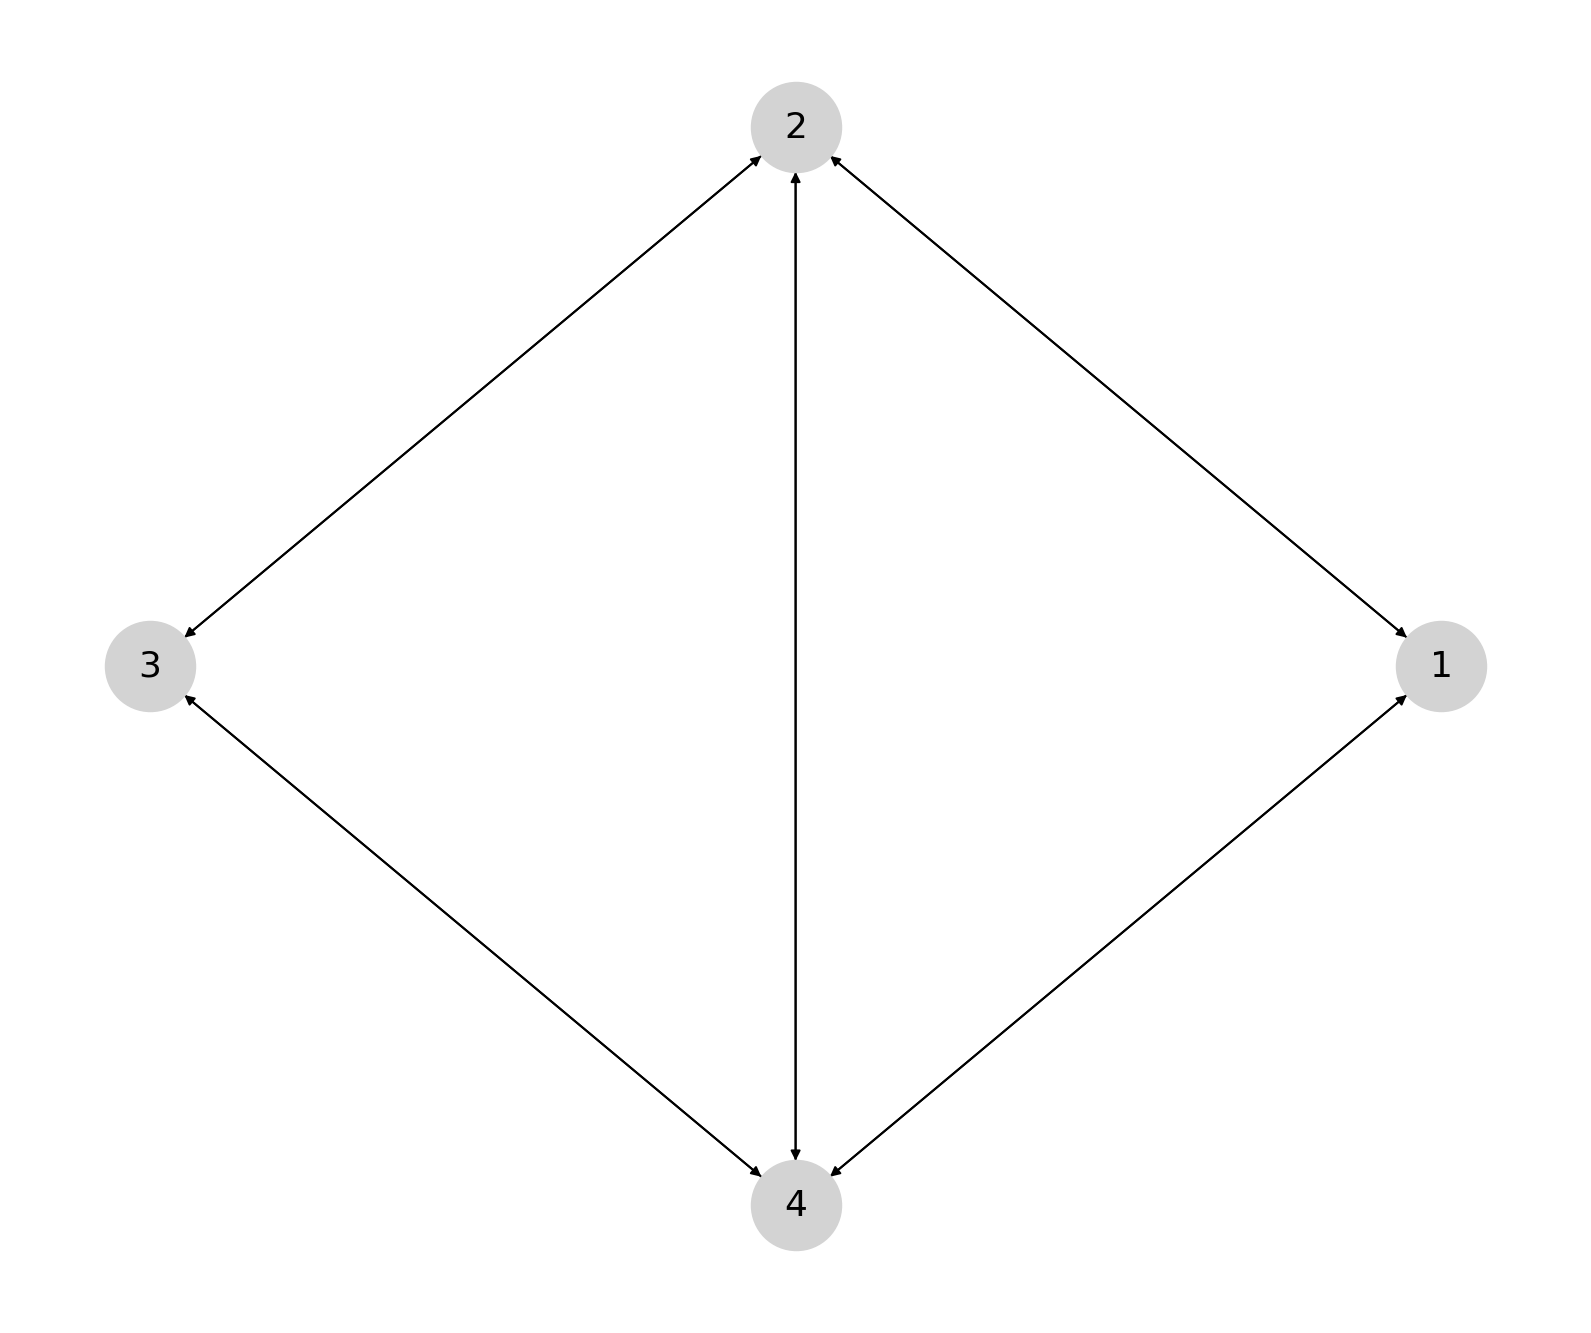

In [7]:
fig, ax = plt.subplots(figsize = (14, 12))
nx.draw(G, pos=nx.circular_layout(G), with_labels=True, node_size=2000, node_color = 'lightgray', font_size=18, font_color='black', font_family='sans-serif')
fig.savefig('figure_4A.pdf', dpi = 900, bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')

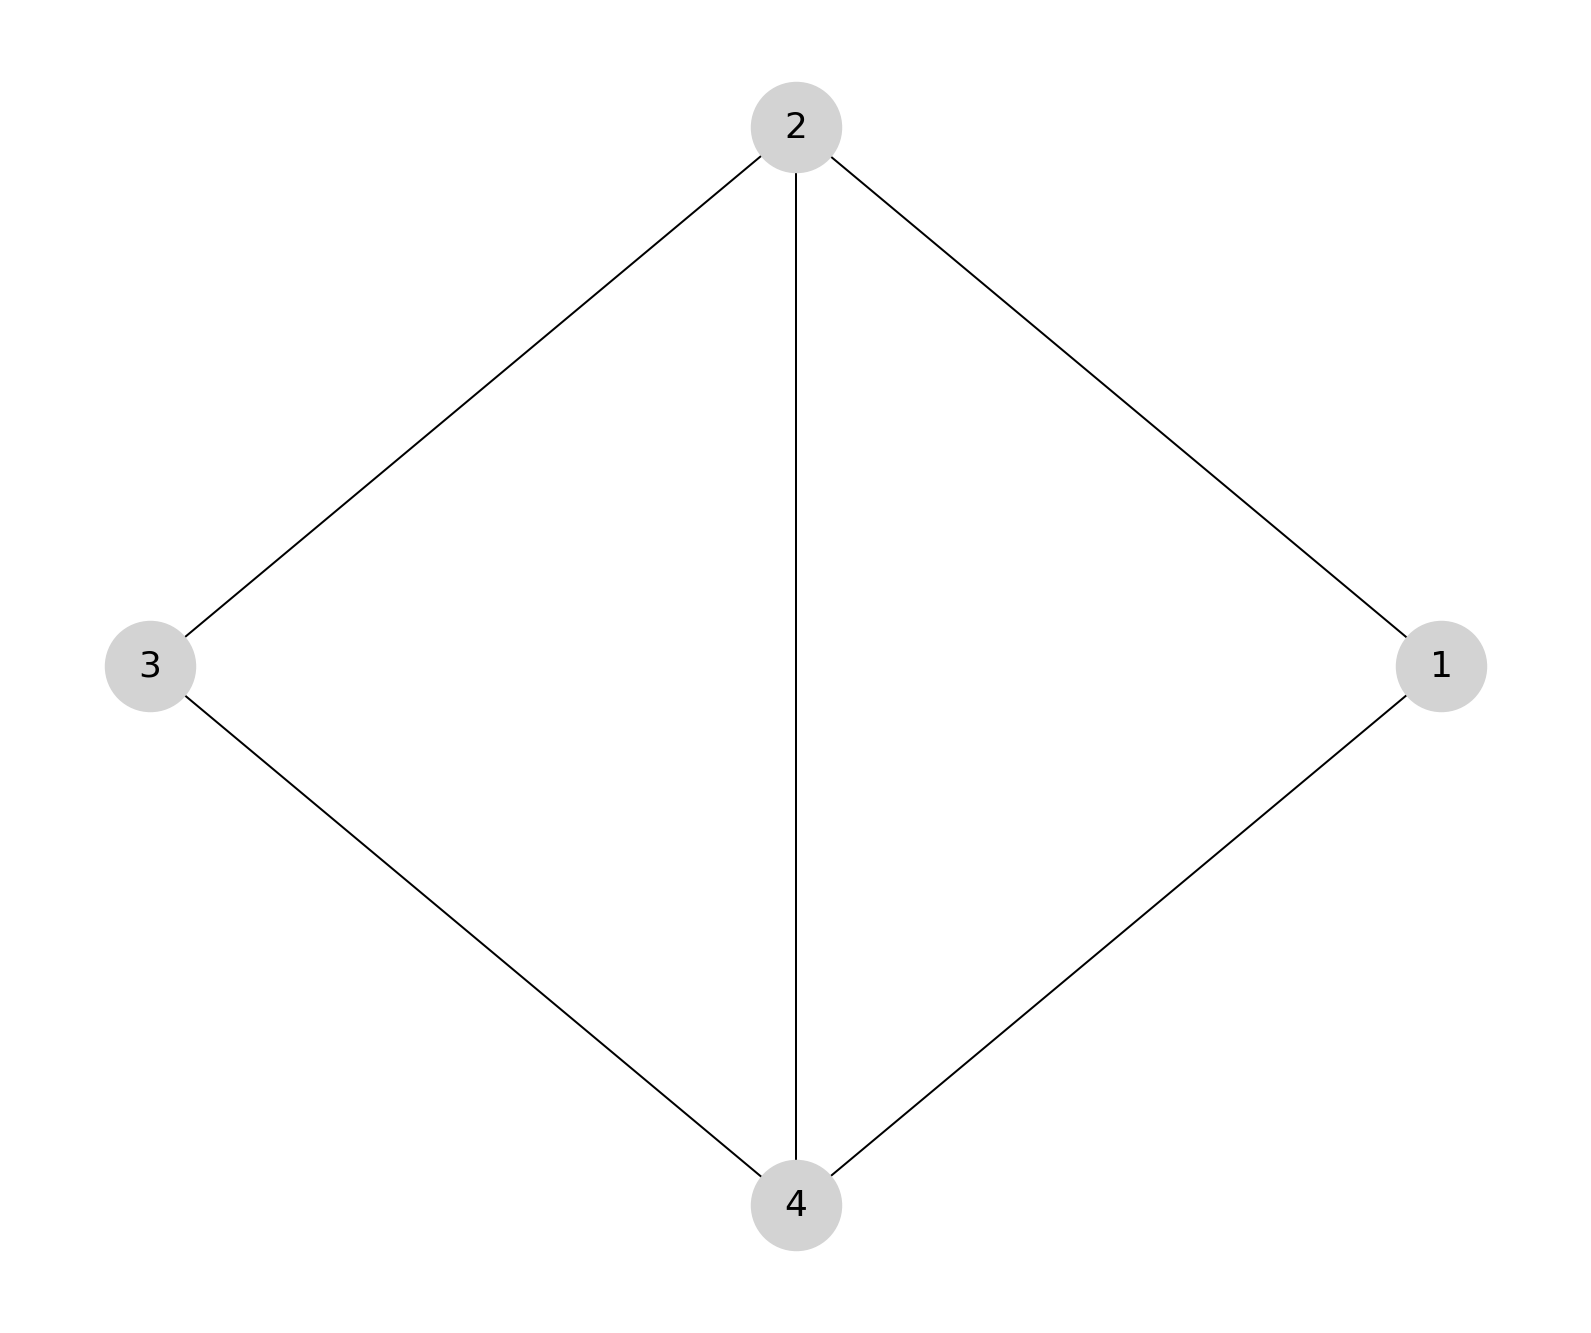

In [8]:
fig, ax = plt.subplots(figsize = (14, 12))
nx.draw(G_ud, pos=nx.circular_layout(G), with_labels=True, node_size=2000, node_color = 'lightgray', font_size=18, font_color='black', font_family='sans-serif')

### 1.1. Create data structures containing the graph's structural information.

Next, we will assign structural information from `G` and `G_ud` to specific data structures, which will be necessary to compute quantities such as the cycle affinity.

Let's begin with the nodes and the edges of $G$.

`node_list`: a ***1D NumPy array*** of the nodes in $G$.

In [11]:
node_list = get_nodes(G)
print(node_list)

[1 2 3 4]


`edge_list`: a ***1D NumPy array*** of the edges in $G$. Each directed edge $i \to j$ between vertices $i$ and $j$ is represented as a list `[i j]`.

In [12]:
edge_list = get_edges(G)
print(edge_list)

[[1 2]
 [1 4]
 [2 1]
 [2 3]
 [3 2]
 [3 4]
 [4 3]
 [4 1]]


Let $C = i \leftrightharpoons 1 \leftrightharpoons 2 \leftrightharpoons \cdots \leftrightharpoons j \leftrightharpoons i$ represent a cycle of reversible edges in a graph. Linear framework graphs can be broken down into cycles (see the work of Terrell Hull and Johannes Schnakenberg for more details on taking a graph theoretic approach to stochastic thermodynamics), which is done by specifying a **cycle basis**.

To define a cycle basis, we take advantage of the NetworkX function `nx.cycle_basis`. More information can be found here: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cycles.cycle_basis.html

`cycle_list`: a ***list of lists*** of the nodes involved in each cycle in $G$. Note that `G_ud`, not `G`, is required here.

`num_cycles`: number of cycles in $G$. This will be an essential parameter in later computations.

In [11]:
cycle_list = get_cycle_nodes(G_ud)
num_cycles = len(cycle_list)
print(cycle_list)
print(num_cycles)

[[4, 2, 1], [4, 3, 2]]
2


To define edge labels for $G$, we use the following algorithm. If G is not labeled, the labels are logarithmically sampled from the range $(10^{-3},10^3)$. Replace `np.around(10**(np.random.uniform(-3,3, size = 1)[0])` with `1.0` in the `elif` condition for troubleshooting purposes.

The function returns the following data structures.

`label_dict`: a dictionary matching each edge to its corresponding label. The keys are the edges (listed as a tuple $(i,j)$ for each directed edge $i\to j$ and the values are the associated labels.

`label_list`: a NumPy array containing a list of the labels in $G$. The order is the same as in `edge_list`, which can be confirmed from `label_dict`

In [12]:
def get_labels(G):
    """
    Extracts the label information for each edge in a NetworkX graph object. If G not labeled, labels are logarithmically sampled.
    
    Note: works for undirected graph, but if given a choice, better to use a directed graph
    
    Parameters
    ----------
    G : NetworkX graph object (directed)
            
    Returns
    -------
    label_dict : dictionary
        keys: edges in G represented as tuple (source,sink), values: edge labels
        
    label_list : 1D numpy array
        list of edge labels in G
        
    """
    
    label_dict = {}
    
    if nx.is_weighted(G)==True:
        for i in range(len(G.edges())):
            label_dict[list(G.edges())[i]] = G.get_edge_data(list(G.edges)[i][0],list(G.edges)[i][1])['weight']
        
    elif nx.is_weighted(G)==False:
        label_dict = {e: 1.0 for e in G.edges}
        # np.around(10**(np.random.uniform(-3,3, size = 1)[0]),decimals=5)
        
    label_list = np.fromiter(label_dict.values(), dtype=float)
    
    return label_dict, label_list

In [13]:
label_dict, label_list = get_labels(G)

In [14]:
print(label_dict)

{(1, 4): 1.0, (1, 2): 1.0, (2, 3): 1.0, (2, 4): 1.0, (2, 1): 1.0, (3, 4): 1.0, (3, 2): 1.0, (4, 1): 1.0, (4, 3): 1.0, (4, 2): 1.0}


In [15]:
print(label_list)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Going forward, it will be useful to specify which edges (and their corresponding labels) are associated with each cycle and to separate forward and backward traversals of each cycle. The next algorithm generates data structures that separate this information.

`cycle_edges_forward`: a ***list of lists*** where each element is a list of the edges going around one direction ("forward") of a given cycle

`cycle_edges_backward`: a ***list of lists*** where each element is a list of the edges going around the opposite direction ("backward") of a given cycle

`cycle_labels_forward`: a ***list of lists*** where each element is a list of the labels associated with the forward edges

`cycle_labels_backward`: a ***list of lists*** where each element is a list of the labels associated with the backward edges

Note that each of these data structures are ***lists of lists***. The indexing for all of them works as follows.

`cycle_edges_forward[i][j]` refers to edge `j` in cycle `i`. `cycle_labels_forward[i][j]` refers to the label on edge `j` in cycle `i`.

In [16]:
cycle_edges_forward,cycle_edges_backward,cycle_labels_forward,cycle_labels_backward = get_cycle_labels_edges(cycle_list,label_dict)

In [17]:
print(cycle_edges_forward)
print(cycle_edges_backward)

[[(2, 3), (3, 4), (4, 1), (1, 2)]]
[[(3, 2), (4, 3), (1, 4), (2, 1)]]


In [18]:
print(cycle_labels_forward)
print(cycle_labels_backward)

[[1.0, 1.0, 1.0, 1.0]]
[[1.0, 1.0, 1.0, 1.0]]


### 1.3. Calculate the cycle affinity for each cycle in the graph

The cycle affinity is a dimensionless quantity that serves as a measure of thermodynamic force. Mathematically, we define the cycle affinity in the following way. Let $C = i \leftrightharpoons 1 \leftrightharpoons 2 \leftrightharpoons \cdots \leftrightharpoons j \leftrightharpoons i$ represent a cycle of reversible edges in a graph. For any cycle $C$, the cycle affinity $\tilde{A}(C)$ is given by

$$ \tilde{A}(C) = ln \left ( \dfrac{\ell(i\to 1)\ell(1\to 2)\cdots \ell(j \to i)}{\ell(1\to i)\ell(2\to 1)\cdots \ell(i \to j)} \right ) $$

where $\ell(a \to b)$ is the label on the directed edge $a \to b$. To compute this quantity for each cycle in the graph, we must complete the following steps.

1. Calculate the products of edge labels in each direction around each cycle.
2. Take the log of the ratio of the forward and backwards products for each cycle

`products_f`: a ***1D NumPy array*** where each element is the product of labels corresponding to the forward traversal of each cycle

`products_b`: a ***1D NumPy array*** where each element is the product of labels corresponding to the backward traversal of each cycle

In [19]:
products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)

In [20]:
print(products_f)
print(products_b)

[1.]
[1.]


`total_affinities`: a ***1D NumPy array*** where each element is the thermodynamic force for each cycle in the graph, corresponding to their order in cycle_list

In [21]:
total_affinities = calculate_affinities(products_b, products_f, cycle_list)

In [22]:
print(total_affinities)

[0.]


### 1.4 Calculate the Laplacian matrix $L$ and the steady state distribution $\pi$ of $G$

`L`: the Laplacian matrix of $G$

In [23]:
L = Laplacian_all(edge_list, label_list, node_list)
print(L)

[[-2.  1.  0.  1.]
 [ 1. -2.  1.  0.]
 [ 0.  1. -2.  1.]
 [ 1.  0.  1. -2.]]


`pi`: the steady-state distribution of $G$

In [24]:
pi = steady_state_spectrum(L)

## 2. Set the graph in an equilibrium steady state

Linear framework graphs represent biochemical systems. The vertices represent components of a system, and edges are treated as chemical reactions under mass-action kinetics with the labels as rate constants (Gunawardena 2012). The dynamics on this system relaxes to a **steady-state** when $dx/dt = 0$, where $x$ is a column vector of component amounts.

Furthermore, we can define two types of steady-states: equilibrium and non-equilibrium. An equilibrium steady-state is characterized by the lack of net fluxes of matter and energy. Detailed balance holds for each pair of reversible edges, and the cycle affinity for each cycle is equal to 0. 

In [25]:
cycle_labels_forward, edge_tracker = initial_equilibrium_parameters(cycle_list,cycle_edges_forward,cycle_labels_forward,cycle_labels_backward)

In [26]:
cycle_labels_forward

[[1.0, 1.0, 1.0, 1.0]]

In [27]:
products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)
total_affinities = calculate_affinities(products_f, products_b, cycle_list)
print(total_affinities)

[0.]


In [39]:
label_dict, label_list = reformat_labels(cycle_list, cycle_labels_forward, edge_tracker, label_dict, label_list)

## 3. Calculate the Steinberg signature

The Steinberg signature is a signature of non-equilibrium conditions in Markovian systems. Using asymmetric autocorrelation functions of the form $\mathcal{A}^{\alpha,\beta}(\tau)$, this method allows one to detect whether or not a given system obeys detailed balance.

We will first define some quantities that will pass as variables in the Steinberg function. We will then compute the Laplacian matrix of the graph. Finally, when we have all the requisite components, we can compute the Steinberg signature.

In [28]:
observable = make_observable(node_list)
print(observable)

[3. 5. 7. 9.]


In [29]:
tau_n = np.arange(start=0.01,stop=20.0,step=0.01)

In [33]:
%%time
t, t_rev = autocorrelation_analytical(observable,L,tau_n,alpha=1,beta=3)

CPU times: user 1.36 s, sys: 24.3 ms, total: 1.38 s
Wall time: 1.43 s


In [34]:
area = np.abs(np.trapz(t)-np.trapz(t_rev))
print(area)

1.318767317570745945e-11


In [32]:
L = np.around(Laplacian_all(edge_list, label_list, node_list),decimals=4)
print(L)

[[-2.  1.  0.  1.]
 [ 1. -2.  1.  0.]
 [ 0.  1. -2.  1.]
 [ 1.  0.  1. -2.]]


In [36]:
pi = steady_state_spectrum(L)

In [36]:
t, t_rev = autocorrelation_analytical(observable,L,tau_n,alpha=1,beta=3)

In [37]:
area = np.abs(np.trapz(t)-np.trapz(t_rev))
print(area)

1.318767317570745945e-11


# 5. Calculate a force-area curve

The goal of developing this software was to determine the sensitivity of the Steinberg signature to the thermodynamic force of the underlying system.

In [42]:
N = 1000
all_affinities = np.zeros((N,num_cycles))
all_areas = np.zeros((N,1))
param_changes = np.zeros((N,1))

In [44]:
for i in tqdm(range(0,N)):
    
    # calculate affinity + record
    products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)
    total_affinities = calculate_affinities(products_f,products_b,cycle_list)
    all_affinities[i] = total_affinities
        
    # calculate area + record
    label_dict, label_list = reformat_labels(cycle_list, cycle_labels_forward, edge_tracker, label_dict, label_list)
    L = Laplacian_all(edge_list,label_list,node_list)
    t, t_rev = autocorrelation_analytical(observable,L,tau_n,alpha=1,beta=3)
    all_areas[i] = np.abs(np.trapz(t)-np.trapz(t_rev))
        
    # perturb parameter + record
    param_changes[i] = cycle_labels_forward[0][0]
    cycle_labels_forward[0][0] = cycle_labels_forward[0][0]*1.01

100%|███████████████████████████████████████| 1000/1000 [22:26<00:00,  1.35s/it]


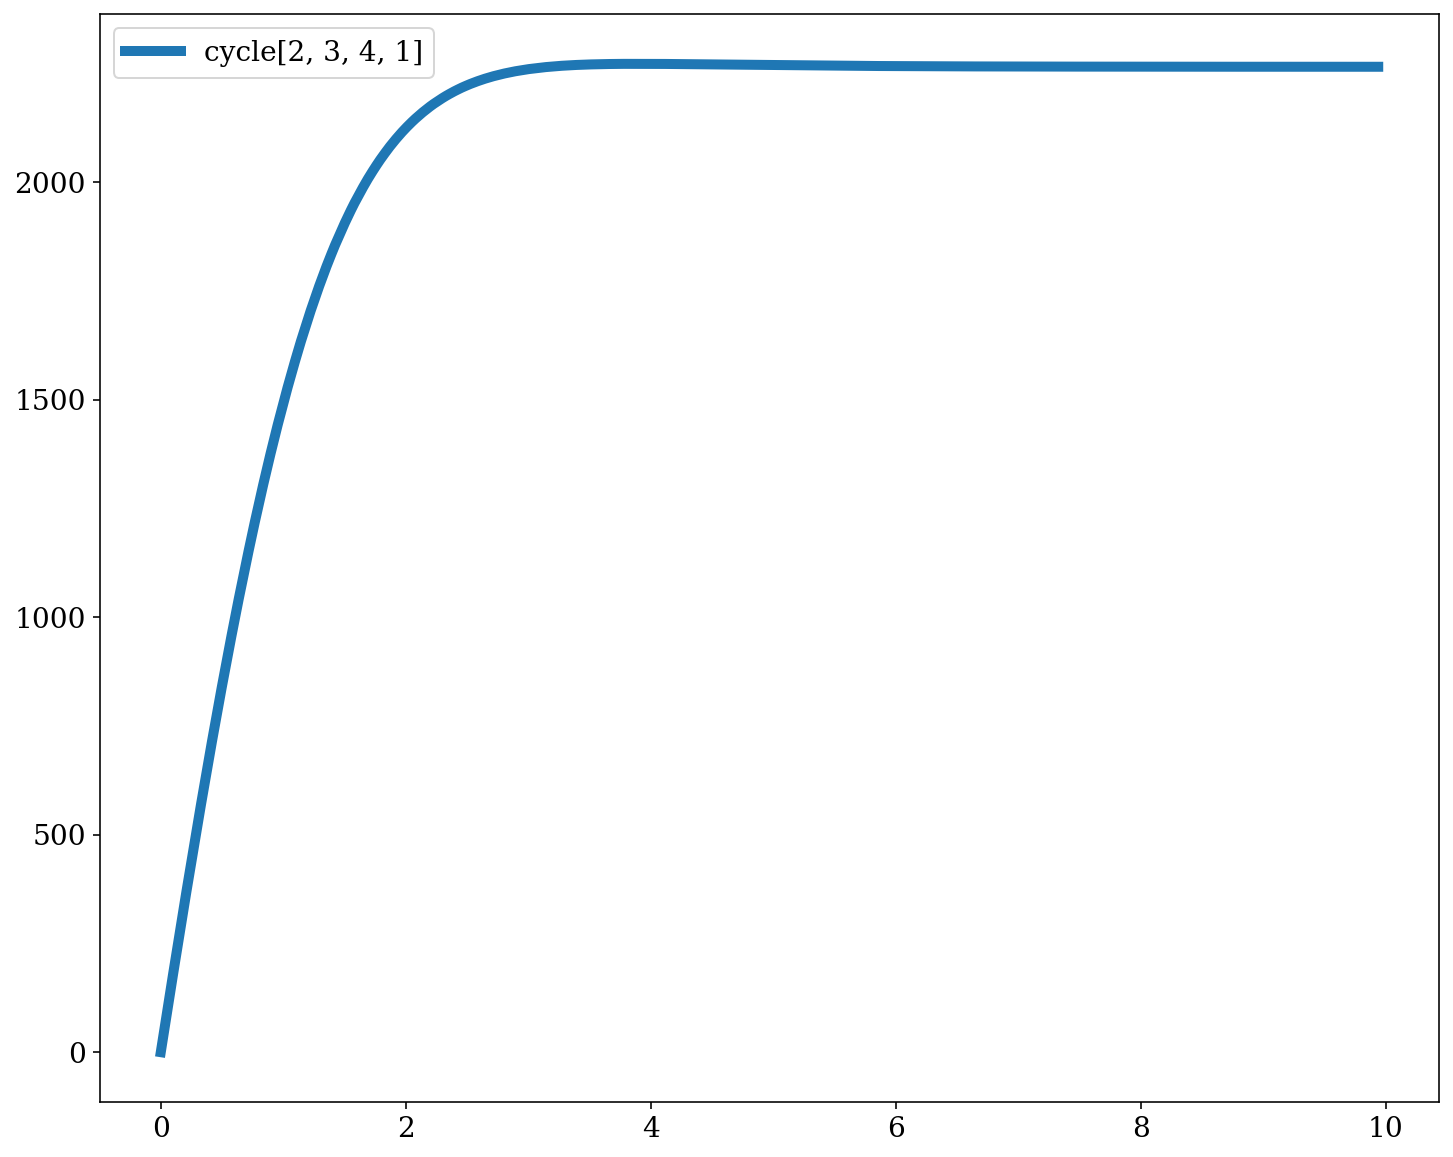

In [47]:
fig = plt.figure()
for i in range(0,num_cycles):
    plt.plot(all_affinities[:,i],all_areas, linewidth=5,label='cycle'+str(cycle_list[i]))
plt.legend()
#fig.savefig('forcearea_affinity-G4-threecycle.png', dpi = 900, bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')

In [310]:
n=6
G,G_ud = random_graph(n)

In [338]:
print(G)
print(G_ud)

DiGraph with 5 nodes and 16 edges
Graph with 5 nodes and 8 edges


In [340]:
G.add_edges_from([(3,4),(4,3)])
G_ud.add_edges_from([(3,4),(4,3)])

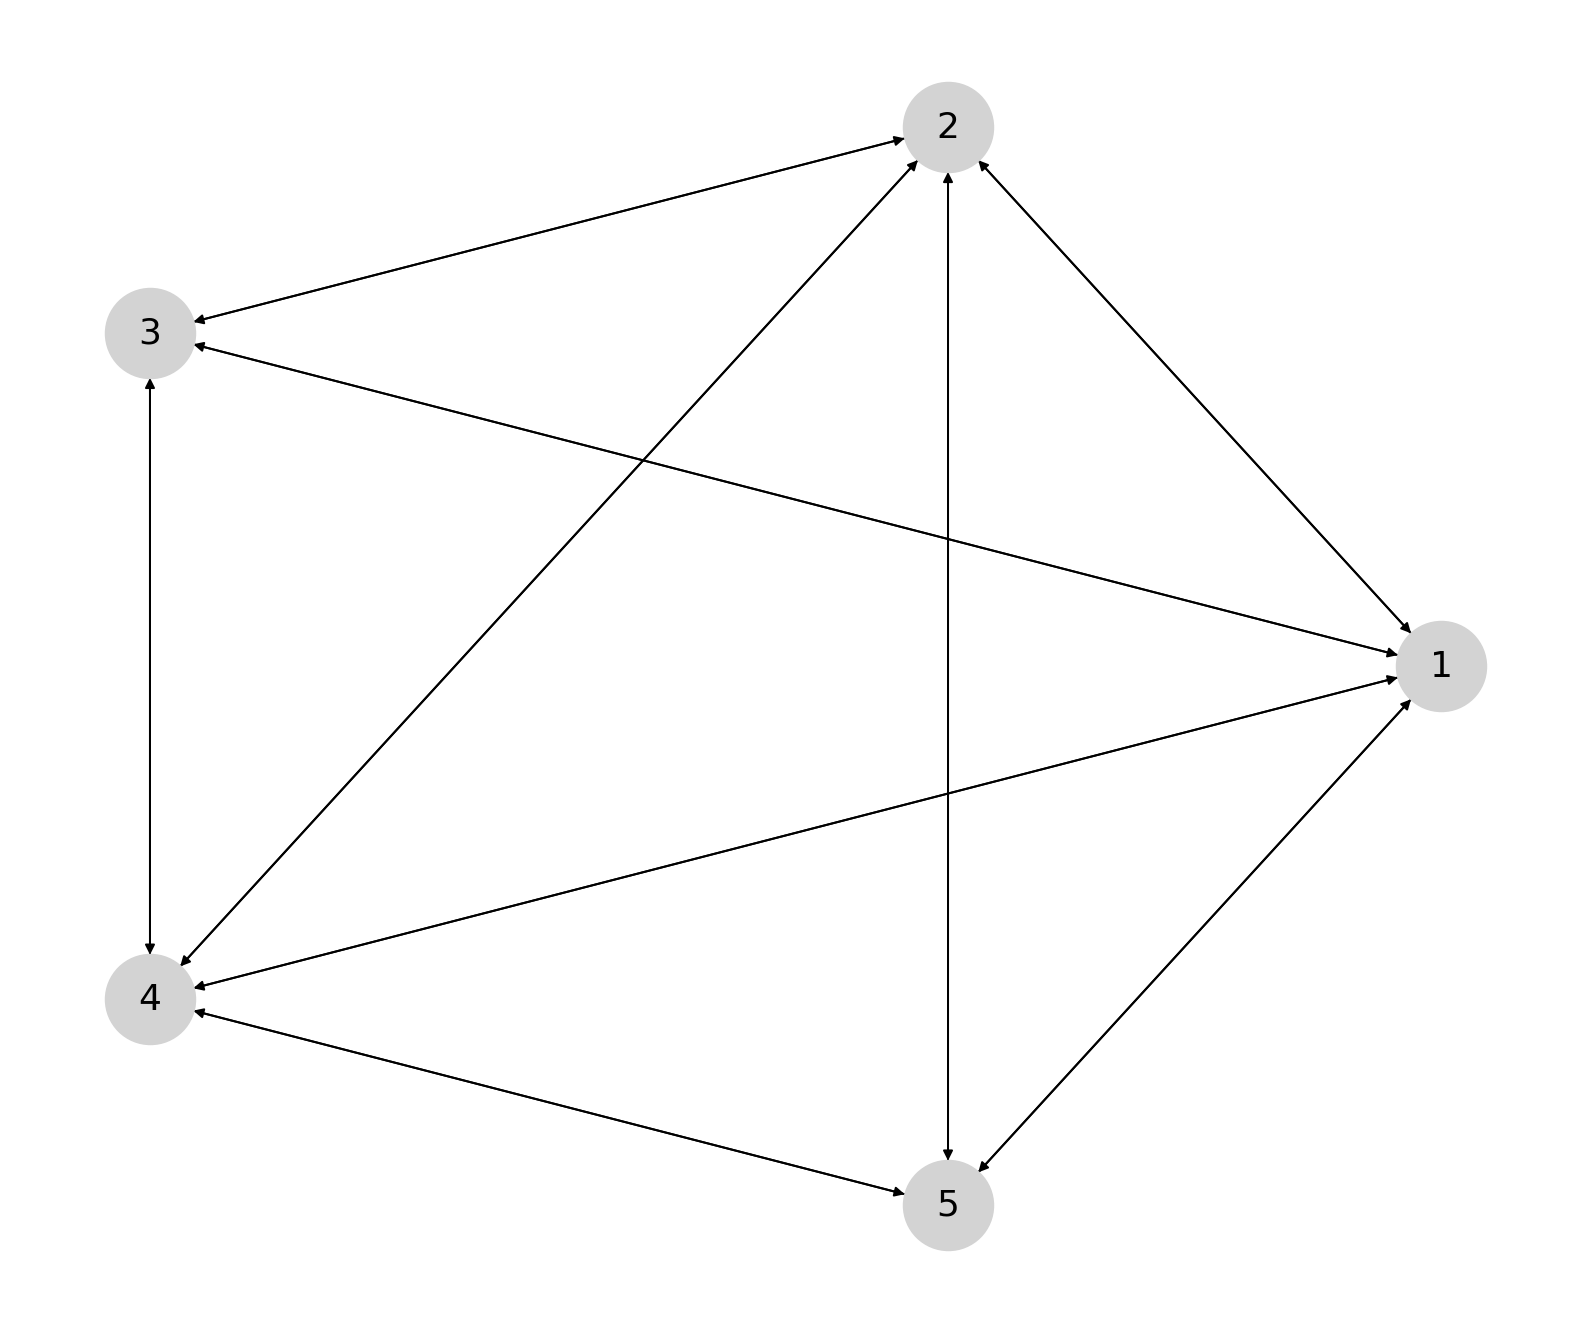

In [341]:
fig, ax = plt.subplots(figsize = (14, 12))
nx.draw(G, pos=nx.circular_layout(G), with_labels=True, node_size=2000, node_color = 'lightgray', font_size=18, font_color='black', font_family='sans-serif')
fig.savefig('figure_4C.pdf', dpi = 900, bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')

In [342]:
node_list = get_nodes(G)
print(node_list)

[1 2 3 4 5]


In [343]:
edge_list = get_edges(G)
print(edge_list)

[[1 2]
 [1 3]
 [1 4]
 [1 5]
 [2 5]
 [2 4]
 [2 3]
 [2 1]
 [3 1]
 [3 2]
 [3 4]
 [4 5]
 [4 2]
 [4 1]
 [4 3]
 [5 1]
 [5 2]
 [5 4]]


In [344]:
label_dict, label_list = get_labels(G)

In [345]:
print(label_dict)

{(1, 2): 1.0, (1, 3): 1.0, (1, 4): 1.0, (1, 5): 1.0, (2, 5): 1.0, (2, 4): 1.0, (2, 3): 1.0, (2, 1): 1.0, (3, 1): 1.0, (3, 2): 1.0, (3, 4): 1.0, (4, 5): 1.0, (4, 2): 1.0, (4, 1): 1.0, (4, 3): 1.0, (5, 1): 1.0, (5, 2): 1.0, (5, 4): 1.0}


In [346]:
print(label_list)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [347]:
cycle_list = get_cycle_nodes(G_ud)
num_cycles = len(cycle_list)
print(cycle_list)

[[5, 4, 1], [2, 4, 1], [3, 4, 1], [2, 3, 1], [5, 2, 1]]


In [348]:
cycle_edges_forward,cycle_edges_backward,cycle_labels_forward,cycle_labels_backward = get_cycle_labels_edges(cycle_list,label_dict)

In [349]:
print(cycle_edges_forward)
print(cycle_edges_backward)

[[(5, 4), (4, 1), (1, 5)], [(2, 4), (4, 1), (1, 2)], [(3, 4), (4, 1), (1, 3)], [(2, 3), (3, 1), (1, 2)], [(5, 2), (2, 1), (1, 5)]]
[[(4, 5), (1, 4), (5, 1)], [(4, 2), (1, 4), (2, 1)], [(4, 3), (1, 4), (3, 1)], [(3, 2), (1, 3), (2, 1)], [(2, 5), (1, 2), (5, 1)]]


In [350]:
print(cycle_labels_forward)
print(cycle_labels_backward)

[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]
[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]


In [351]:
products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)

In [352]:
print(products_f)
print(products_b)

[1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1.]


In [353]:
total_affinities = calculate_affinities(products_b, products_f, cycle_list)

In [354]:
print(total_affinities)

[0. 0. 0. 0. 0.]


In [355]:
signal = make_observable(node_list)
print(signal)

[3, 5, 7, 9, 11]


In [356]:
tau_n = np.arange(start=0.01,stop=2.0,step=0.01)

In [357]:
L = Laplacian_all(edge_list, label_list, node_list)
print(L)

[[-4.  1.  1.  1.  1.]
 [ 1. -4.  1.  1.  1.]
 [ 1.  1. -3.  1.  0.]
 [ 1.  1.  1. -4.  1.]
 [ 1.  1.  0.  1. -3.]]


In [358]:
cycle_labels_forward, edge_tracker = initial_equilibrium_parameters(cycle_list,cycle_edges_forward,cycle_labels_forward,cycle_labels_backward)

In [359]:
cycle_labels_forward

[[1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0]]

In [360]:
products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)
total_affinities = calculate_affinities(products_f, products_b, cycle_list)
print(total_affinities)

[0. 0. 0. 0. 0.]


In [361]:
label_dict, label_list = reformat_labels(cycle_list, cycle_labels_forward, edge_tracker, label_dict, label_list)

In [362]:
L = np.around(Laplacian_all(edge_list, label_list, node_list),decimals=4)
print(L)

[[-4.  1.  1.  1.  1.]
 [ 1. -4.  1.  1.  1.]
 [ 1.  1. -3.  1.  0.]
 [ 1.  1.  1. -4.  1.]
 [ 1.  1.  0.  1. -3.]]


In [363]:
area = np.abs(np.trapz(t)-np.trapz(t_rev))
print(area)

2.7239366318099200726e-10


In [364]:
N = 2000
all_affinities = np.zeros((N,num_cycles))
all_areas = np.zeros((N,1))
param_changes = np.zeros((N,1))

In [365]:
for i in tqdm(range(0,N)):
    
    # calculate affinity + record
    products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)
    total_affinities = calculate_affinities(products_f,products_b,cycle_list)
    all_affinities[i] = total_affinities
    
    # calculate area + record
    label_dict, label_list = reformat_labels(cycle_list, cycle_labels_forward, edge_tracker, label_dict, label_list)
    L = Laplacian_all(edge_list,label_list,node_list)
    pi = steady_state_spectrum(L)
    a_13, a_31 = asymmetric_autocorrelation(signal,L,tau,pi,alpha=1,beta=3)
    all_areas[i] = np.abs(np.trapz(a_13)-np.trapz(a_31))
    
    # perturb parameter + record
    param_changes[i] = cycle_labels_forward[0][0]
    cycle_labels_forward[0][0] = cycle_labels_forward[0][0]*1.01

100%|█████████████████████████████████████████| 2000/2000 [06:03<00:00,  5.50it/s]


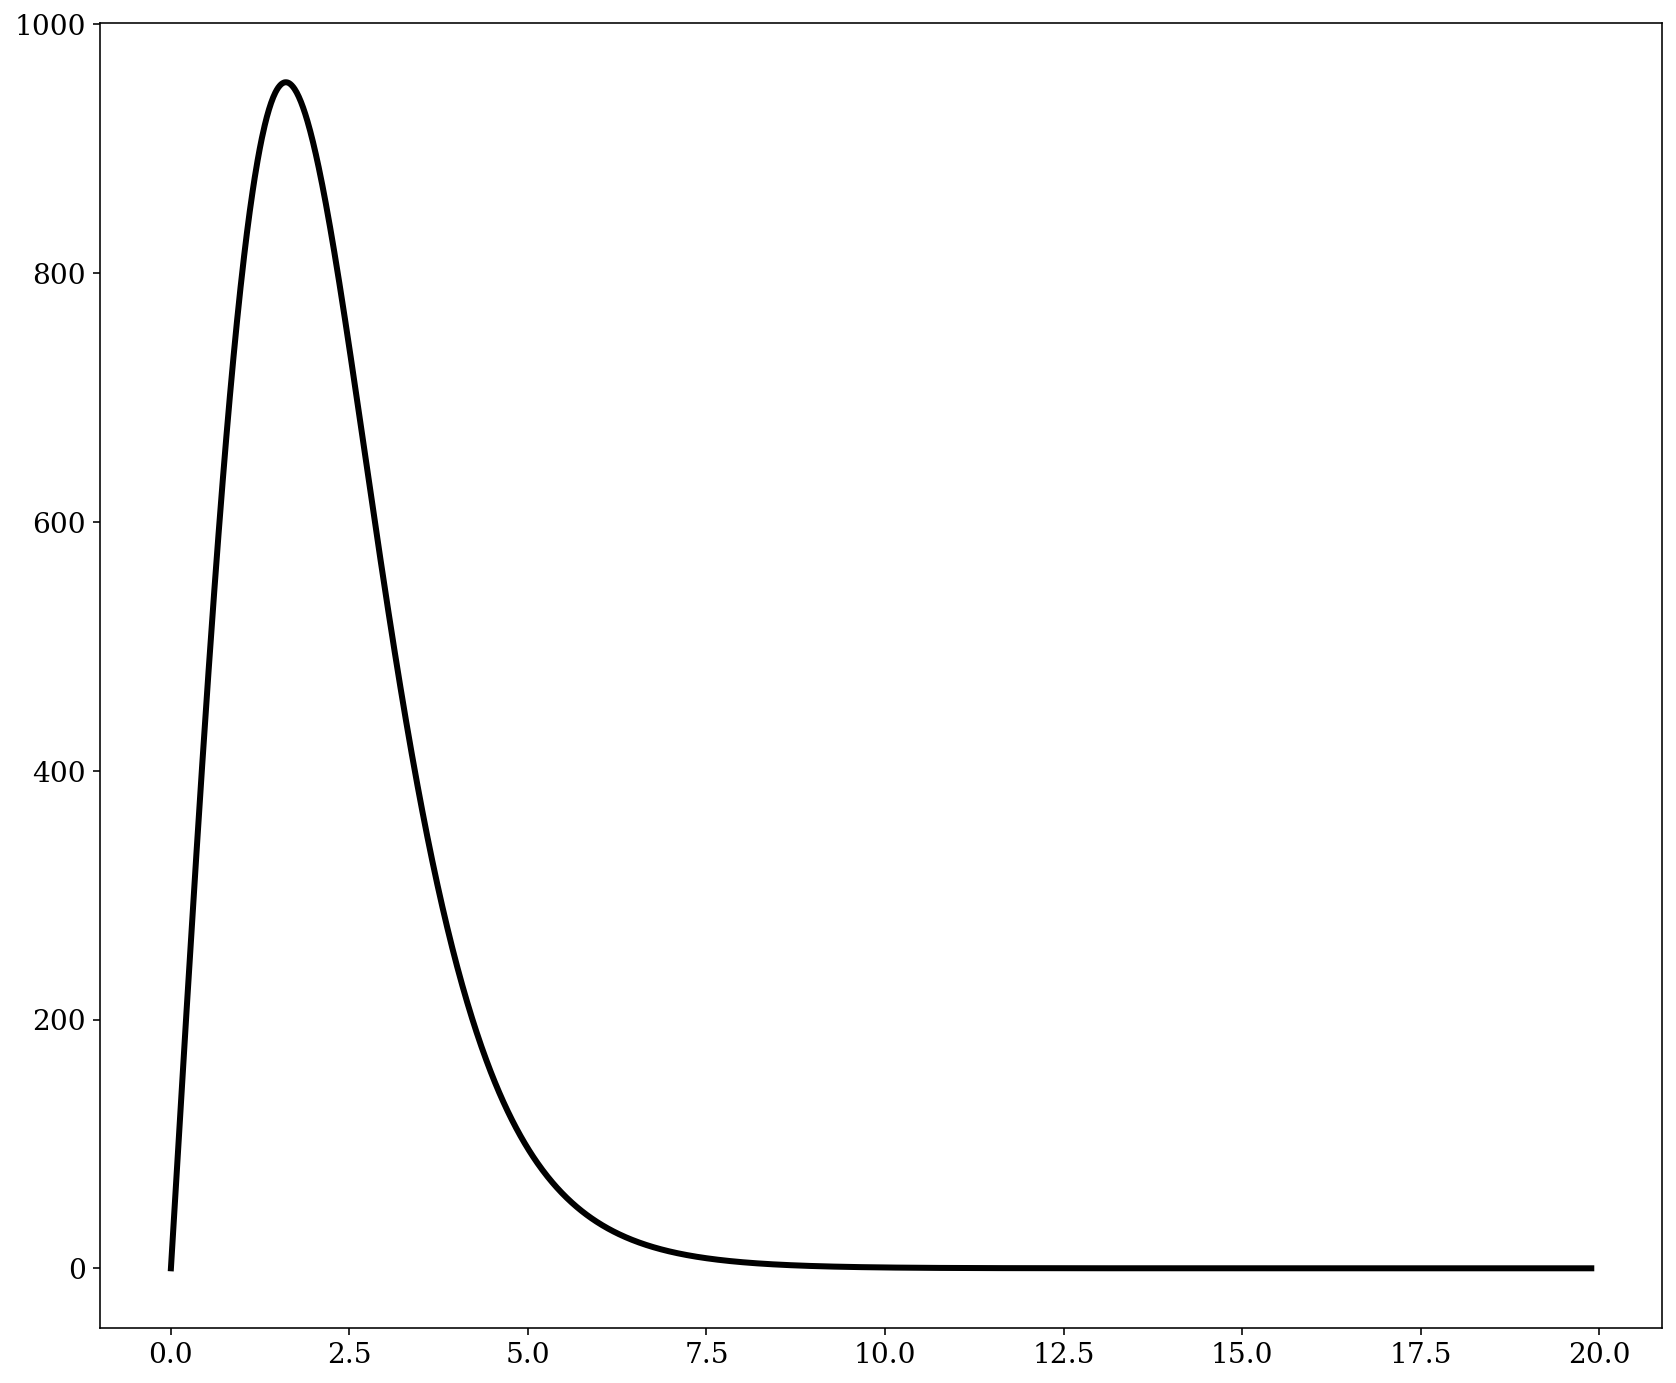

In [337]:
fig, ax = plt.subplots(figsize = (14, 12))
plt.plot(all_affinities[:,0],all_areas, linewidth=3, color = '#000000',label='cycle'+str(i))
plt.show()
fig.savefig('figure_4D.pdf', dpi = 900, bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')